# Crypto Currency Cross-Prediction 04

This time the data would be preprocessed to be the average of the next n days.

```
Y(t) = AVG(P(t+1), P(t+2), ..., P(t+n)) / n
Y - Future average prediction
P - price
t - time (day)
n - Vision window size
```

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

In [17]:
def futureAverage(data, visionWindowSize):
  return np.array([np.mean(data[i:i+visionWindowSize]) for i in range(len(data) - visionWindowSize)])

In [ ]:
btc_data = pd.read_csv('data/BTCUSDT_1D_2.csv')
bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')

#### [Model1] BNB -> BNB, Vision = 14

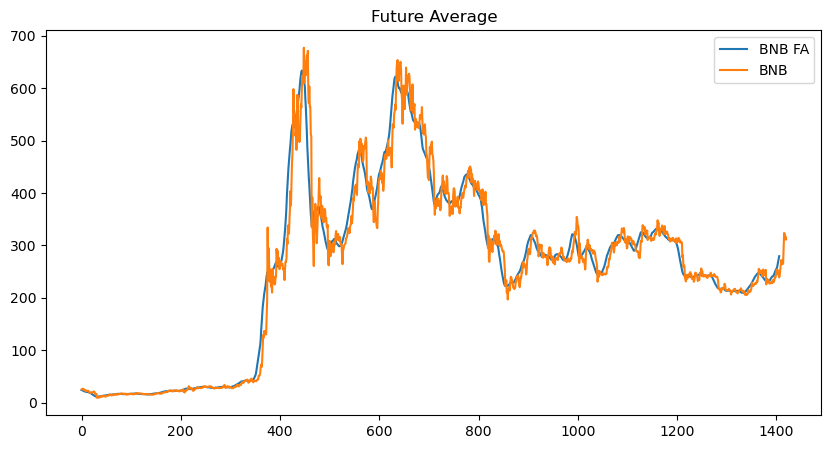

In [41]:
visionWindowSize = 14

bnb_fa_data = futureAverage(bnb_data["Close"], visionWindowSize)

plt.figure(figsize=(10, 5))
plt.plot(bnb_fa_data, label="BNB FA")
plt.plot(bnb_data["Close"], label="BNB")
plt.title("Future Average")
plt.legend()

In [42]:
windowSize = 35

# crop viable input
bnb_input_data  = np.array(bnb_data["Close"][:-visionWindowSize])

dataSize = len(bnb_input_data)
assert(dataSize == len(bnb_fa_data))
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 1407
windowSize: 35
testSize: 422


Trivial prediction brenchmarking

In [43]:
y_test = prepareTestingOutputs(bnb_fa_data, testSize)
prediction0 = np.array(bnb_input_data[range(dataSize - testSize - 1, dataSize - 1)])

rmse1_b = tf.keras.metrics.RootMeanSquaredError()(y_test, prediction0)
print(f"RootMeanSquaredError {rmse1_b}")
corr1_b = np.corrcoef(prediction0, y_test)[0, 1]
print(f"Correlation {corr1_b}")

RootMeanSquaredError 16.081106185913086
Correlation 0.9192920152360669


In [34]:
x_train = prepareTrainingInputs(bnb_input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_fa_data, windowSize, testSize)
x_test = prepareTestingInputs(bnb_input_data, windowSize, testSize)
# y_test = prepareTestingOutputs(bnb_fa_data, testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train, y_train, x_test, y_test)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=windowSize, name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 35),         824868      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 35)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [35]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True, verbose=1),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 135: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 35.

Epoch 235: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 235: early stopping


14/14 [==============================] - 2s 21ms/step - loss: 13.3784 - mae: 13.3784 - mse: 352.0167
rmse1: 18.762107907035244


<Figure size 640x480 with 0 Axes>

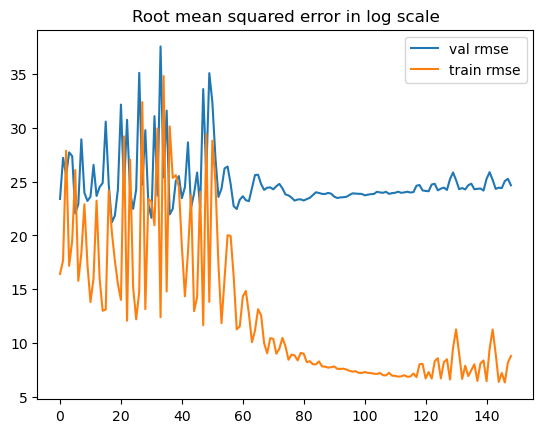

<Figure size 640x480 with 0 Axes>

In [36]:
rmse1 = np.sqrt(model1.evaluate(np.array(x_test), y_test)[2])
print(f"rmse1: {rmse1}")

# plot error
plotHistoryRSME(history1)
plt.figure()

corr: 0.8951287306149903


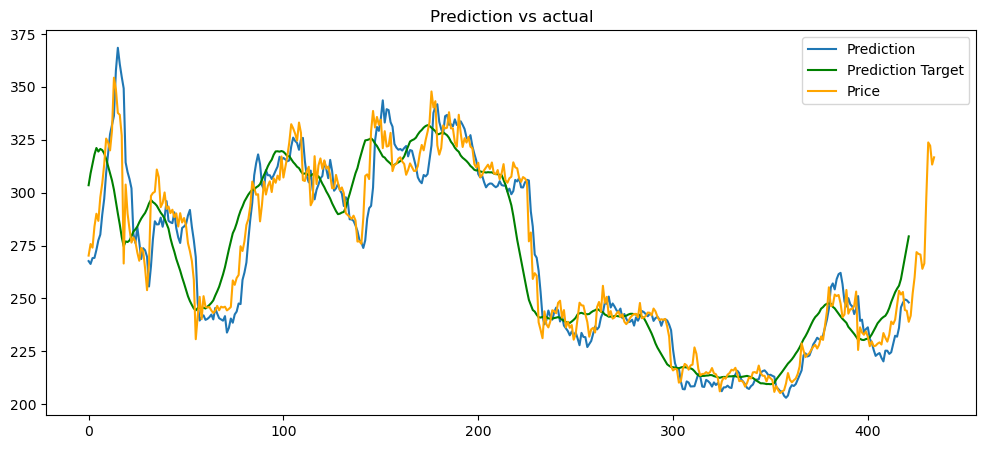

In [37]:
# plot prediction
prediction1 = model1.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(prediction1, label='Prediction')
plt.plot(y_test, label='Prediction Target', color='green')
plt.plot(np.array(bnb_data["Close"][-visionWindowSize-testSize:-1]), label='Price', color="orange")
plt.title('Prediction vs actual')
plt.legend()

corr1 = np.corrcoef(prediction1.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr1}")

The performance seems similar to the model without future averaging.

#### [Model2] Increase vision window size. Vision = 28

In [44]:
visionWindowSize = 28

bnb_fa_data = futureAverage(bnb_data["Close"], visionWindowSize)

windowSize = 35

# crop viable input
bnb_input_data = np.array(bnb_data["Close"][:-visionWindowSize])

dataSize = len(bnb_input_data)
assert(dataSize == len(bnb_fa_data))
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 1393
windowSize: 35
testSize: 418


Trivial prediction brenchmarking

In [45]:
y_test = prepareTestingOutputs(bnb_fa_data, testSize)
prediction0 = np.array(bnb_input_data[range(dataSize - testSize - 1, dataSize - 1)])

rmse2_b = tf.keras.metrics.RootMeanSquaredError()(y_test, prediction0)
print(f"RootMeanSquaredError {rmse2_b}")
corr2_b = np.corrcoef(prediction0, y_test)[0, 1]
print(f"Correlation {corr2_b}")

RootMeanSquaredError 20.047924041748047
Correlation 0.871343663958947



Epoch 130: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 30.

Epoch 230: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 230: early stopping
14/14 [==============================] - 2s 15ms/step - loss: 16.2854 - mae: 16.2854 - mse: 476.3922
rmse2: 21.826410181165485
corr: 0.8588921175845671


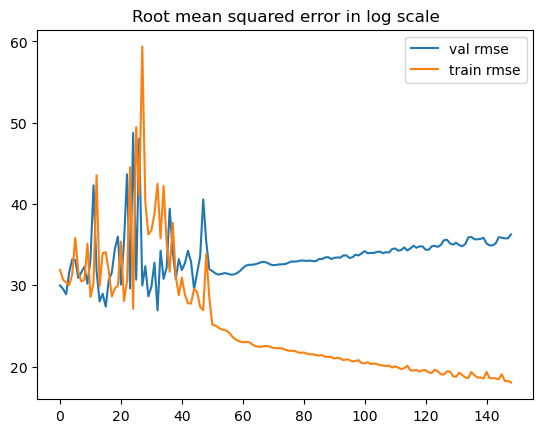

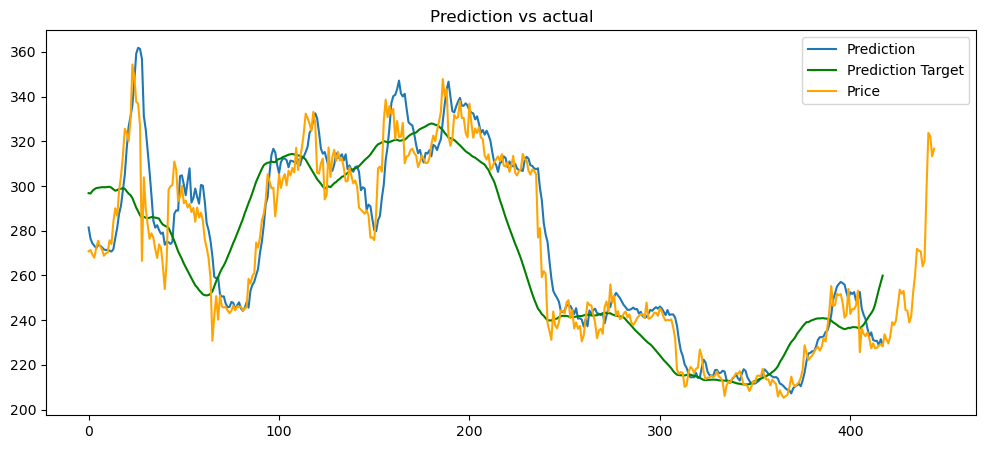

In [46]:
x_train = prepareTrainingInputs(bnb_input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_fa_data, windowSize, testSize)
x_test = prepareTestingInputs(bnb_input_data, windowSize, testSize)
# y_test = prepareTestingOutputs(bnb_fa_data, testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train, y_train, x_test, y_test)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=windowSize, name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model2 = tf.keras.Model(inputs=input, outputs=x)
# model2.summary()

model2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history2 = model2.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True, verbose=1),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

rmse2 = np.sqrt(model2.evaluate(np.array(x_test), y_test)[2])
print(f"rmse2: {rmse2}")

# plot error
plotHistoryRSME(history2)

# plot prediction
prediction2 = model2.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(prediction2, label='Prediction')
plt.plot(y_test, label='Prediction Target', color='green')
plt.plot(np.array(bnb_data["Close"][-visionWindowSize-testSize:-1]), label='Price', color="orange")
plt.title('Prediction vs actual')
plt.legend()

corr2 = np.corrcoef(prediction2.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr2}")


No improvement is done for this model

#### [Model3] With BTC data


Epoch 125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 25.

Epoch 225: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 225: early stopping
14/14 [==============================] - 2s 15ms/step - loss: 23.3547 - mae: 23.3547 - mse: 826.2807
rmse3: 28.745098724540743
corr: 0.6683426816277542


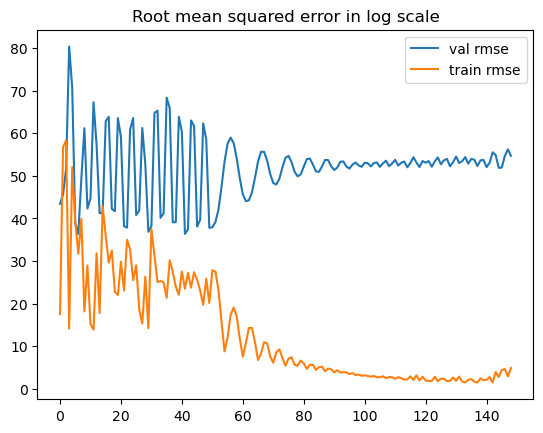

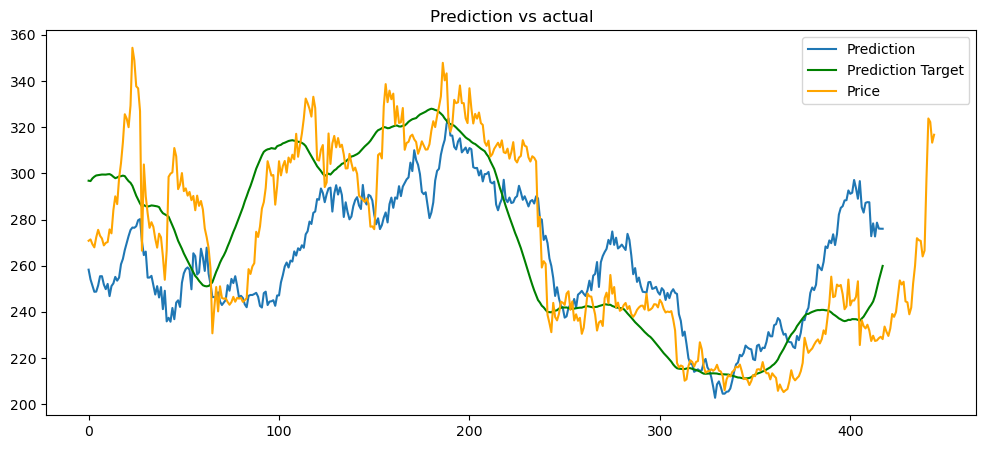

In [50]:
BTC_FOR_BNB_SCALE = 90

btc_input_data = np.array(btc_data["Close"][:-visionWindowSize])

# x_train = prepareTrainingInputs(bnb_input_data, windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_input_data, windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train3 = np.array([np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))])
# y_train = prepareTraingingOutputs(bnb_fa_data, windowSize, testSize)

# x_test = prepareTestingInputs(bnb_input_data, windowSize, testSize)
x_test_btc = prepareTestingInputs(btc_input_data, windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test3 = np.array([np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))])
# y_test = prepareTestingOutputs(bnb_fa_data, testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train3, y_train, x_test3, y_test)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=windowSize*2, name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model3 = tf.keras.Model(inputs=input, outputs=x)
# model3.summary()

model3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history3 = model3.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True, verbose=1),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

rmse3 = np.sqrt(model3.evaluate(x_test3, y_test)[2])
print(f"rmse3: {rmse3}")

# plot error
plotHistoryRSME(history3)

# plot prediction
prediction3 = model3.predict(x_test3)

plt.figure(figsize=(12, 5))
plt.plot(prediction3, label='Prediction')
plt.plot(y_test, label='Prediction Target', color='green')
plt.plot(np.array(bnb_data["Close"][-visionWindowSize-testSize:-1]), label='Price', color="orange")
plt.title('Prediction vs actual')
plt.legend()

corr3 = np.corrcoef(prediction3.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr3}")

In [51]:
model3.save('models/model4-3')

INFO:tensorflow:Assets written to: models/model4-3\assets


INFO:tensorflow:Assets written to: models/model4-3\assets
